In [ ]:
import pandas as pd
import random
import numpy as np
from sklearn.metrics import precision_score, recall_score, roc_auc_score, f1_score, accuracy_score

from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.neural_network import MLPClassifier
import xgboost as xgb
import lightgbm as lgb

import matplotlib
import matplotlib.pyplot as plt

In [ ]:
#евклидово расстояние
def euclid_distance(data, x = '', y ='.1'):
    data['eucl'] = np.sqrt((data['ra' + x] - data['ra' + y])**2 + (data['dec' + x] - data['dec' + y])**2) 
    return data

    
#графики

def barplot(x_data, y_data, error_data, x_label="", y_label="", title="", cnt_l = 40, cnt_r = 15):
    fig, ax = plt.subplots(figsize = (cnt_l, cnt_r))
    # Draw bars, position them in the center of the tick mark on the x-axis
    ax.bar(x_data, y_data, color = '#539caf', align = 'center', width = 0.9)
    # Draw error bars to show standard deviation, set ls to 'none'
    # to remove line between points
    ax.errorbar(x_data, y_data, color = '#297083', ls = 'none', lw = 2, capthick = 2)
    ax.set_ylabel(y_label)
    ax.set_xlabel(x_label)
    ax.set_title(title)

    
    plt.show()

Загрузка и обработка данных (по аналогии с Gaia x allWISE + добавление шума)

In [ ]:
no_data = pd.DataFrame()
for i in range(6, 10): #5,6
    no_match_data = pd.read_csv("no_match_allwise_" + str(i) + ".csv")
    no_data = pd.concat([no_data, no_match_data], axis = 0)
for i in range(1, 7): #5,6
    no_match_data = pd.read_csv("no_match_allwise" + str(i) + ".csv")
    no_data = pd.concat([no_data, no_match_data], axis = 0)

no_data = no_data.drop_duplicates()

no_data['ra'] = no_data['ra'] + [random.uniform(-1, 1) for i in range(0, len(no_data))]
no_data['dec'] = no_data['dec'] + [random.uniform(-1, 1) for i in range(0, len(no_data))]
no_data['r'] = [random.uniform(-0.5, 0.5) for i in range(0, len(no_data))]
no_data['matched'] = 0
print(len(no_data))

In [7]:
no_data.head()

,allwise_oid,designation,ra,dec,ra_error,dec_error,radec_co_error,w1mpro,w1mpro_error,w2mpro,...,radius_percentile_lower,radius_percentile_upper,lum_val,lum_percentile_lower,lum_percentile_upper,datalink_url,epoch_photometry_url,score,r,matched
0,849951,J062235.52-862020.8,95.133894,-86.365869,0.6135,0.5690,0.1592,17.918,0.174,17.854,...,NaN,NaN,NaN,NaN,NaN,https://gea.esac.esa.int/data-server/datalink/...,NaN,NaN,-0.245156,0
1,849964,J223651.28-862020.7,340.041723,-87.119776,0.5365,0.4912,-0.1214,17.786,0.166,17.731,...,NaN,NaN,NaN,NaN,NaN,https://gea.esac.esa.int/data-server/datalink/...,NaN,NaN,-0.138921,0
2,851746,J233926.34-862007.0,353.918221,-86.697508,0.6831,0.6230,-0.0483,18.149,0.217,17.111,...,NaN,NaN,NaN,NaN,NaN,https://gea.esac.esa.int/data-server/datalink/...,NaN,NaN,0.203965,0
3,852696,J124342.62-861959.4,190.675765,-86.898634,0.5600,0.5328,0.1641,17.978,0.185,17.579,...,NaN,NaN,NaN,NaN,NaN,https://gea.esac.esa.int/data-server/datalink/...,NaN,NaN,0.441479,0
4,860554,J085310.47-861857.0,132.752962,-85.503490,0.6535,0.6282,-0.1823,18.103,0.200,17.622,...,NaN,NaN,NaN,NaN,NaN,https://gea.esac.esa.int/data-server/datalink/...,NaN,NaN,-0.475804,0


In [8]:
data = pd.DataFrame()
for i in range(4, 6): #2,3
    match_data = pd.read_csv("match_allwise_" + str(i) + ".csv")
    data = pd.concat([data, match_data], axis = 0)
for i in range(1, 6): #2,3
    match_data = pd.read_csv("match_allwise" + str(i) + ".csv")
    data = pd.concat([data, match_data], axis = 0)

data = data.drop_duplicates()
data['ra'] = data['ra'] + [random.uniform(-1, 1) for i in range(0, len(data))]
data['dec'] = data['dec'] + [random.uniform(-1, 1) for i in range(0, len(data))]
print(len(data))
data['matched'] = 1

12873


In [9]:
no_data1 = (euclid_distance(no_data))[['eucl','ra','dec','ra.1','dec.1','phot_g_mean_flux', 'phot_bp_mean_flux', 'phot_rp_mean_flux', 'w1mpro', 'w2mpro', 'w3mpro','w4mpro', 'matched']]
data1 = (euclid_distance(data))[['eucl','ra','dec','ra.1','dec.1','phot_g_mean_flux', 'phot_bp_mean_flux', 'phot_rp_mean_flux', 'w1mpro', 'w2mpro', 'w3mpro','w4mpro', 'matched']]

no_data1 = no_data1.dropna()
data1 = data1.dropna()

In [ ]:
x1 = no_data1[no_data1['eucl'] < 1].sample(frac = 0.13)
print(len(x1))
print(len(x1.dropna()))

x2 = data1[data1['eucl'] > 0.5].sample(frac = 0.01)
print(len(x2))
print(len(x2.dropna()))

x = pd.concat([x1, x2], axis = 0)
n1 = len(x)

x1 = no_data1[no_data1['eucl'] > 1].sample(frac = 0.08)
print(len(x1))
print(len(x1.dropna()))
print(len(x1.dropna()))

x2 = data1[data1['eucl'] < 0.5].sample(frac = 0.35)
print(len(x2))
print(len(x2.dropna()))

n2 = len(pd.concat([x1, x2], axis = 0))
x = pd.concat([x, x1, x2], axis = 0)

In [11]:
print(n1/ (n1+n2))

0.10780065005417118


In [12]:
dff1 = x[['ra','dec','ra.1','dec.1','phot_g_mean_flux', 'phot_bp_mean_flux', 'phot_rp_mean_flux', 'w1mpro', 'w2mpro', 'w3mpro','w4mpro', 'matched']]

In [13]:
print(len(dff1))
print(len(dff1.dropna()))
dff1 = dff1.dropna()
y1 = dff1['matched']
dff2 = dff1.drop(columns= ['matched'])#, 'match']

1846
1846


Создание обучающих и тестовых наборов, проверка работоспособности моделей

In [15]:
X_train, X_val, y_train, y_val = train_test_split(dff2, y1, test_size=0.7, random_state=80, shuffle = True) #0.7

In [16]:
dt = DecisionTreeClassifier()
dt = dt.fit(X_train, y_train)
res = dt.predict(X_val)

print('accuracy_score: ', accuracy_score(y_val, res))
print('precision_score: ', precision_score(y_val, res))
print('recall_score: ', recall_score(y_val, res))
print('f1_score: ', f1_score(y_val, res))
print()

print(dt.n_features_)
weight_f = dt.feature_importances_
print(weight_f)

accuracy_score:  0.9930394431554525
precision_score:  0.995475113122172
recall_score:  0.990990990990991
f1_score:  0.9932279909706545

11
[0.04215591 0.55850877 0.         0.38527057 0.         0.
 0.         0.         0.         0.01406474 0.        ]


In [17]:
model = xgb.XGBClassifier()
model = model.fit(X_train, y_train)
res_xgb = model.predict(X_val)
res = res_xgb

print('accuracy_score: ', accuracy_score(y_val, res))
print('precision_score: ', precision_score(y_val, res))
print('recall_score: ', recall_score(y_val, res))
print('f1_score: ', f1_score(y_val, res))
print()
model.feature_importances_

accuracy_score:  0.9953596287703016
precision_score:  0.9940119760479041
recall_score:  0.996996996996997
f1_score:  0.9955022488755623



array([0.07918742, 0.53750193, 0.00816493, 0.24721947, 0.00688948,
       0.00540054, 0.00427946, 0.00224813, 0.00551438, 0.09575695,
       0.00783725], dtype=float32)

In [18]:
x, xe, y1, ye = train_test_split(X_train, y_train, test_size=0.35, random_state=22, )
model1 = lgb.LGBMClassifier(n_estimators=100, silent=True,  num_leaves = 25, learning_rate = 0.03, random_state = 27)
model1 = model1.fit(x, y1,   eval_set=[(xe, ye)], early_stopping_rounds=100)
res_lgb = model1.predict(X_val)
res = res_lgb

print('accuracy_score: ', accuracy_score(y_val, res))
print('precision_score: ', precision_score(y_val, res))
print('recall_score: ', recall_score(y_val, res))
print('f1_score: ', f1_score(y_val, res))
print()
model1.feature_importances_

[1]	valid_0's binary_logloss: 0.666804
Training until validation scores don't improve for 100 rounds
[2]	valid_0's binary_logloss: 0.640726
[3]	valid_0's binary_logloss: 0.616223
[4]	valid_0's binary_logloss: 0.592949
[5]	valid_0's binary_logloss: 0.571078
[6]	valid_0's binary_logloss: 0.550183
[7]	valid_0's binary_logloss: 0.530743
[8]	valid_0's binary_logloss: 0.511896
[9]	valid_0's binary_logloss: 0.494059
[10]	valid_0's binary_logloss: 0.476993
[11]	valid_0's binary_logloss: 0.46083
[12]	valid_0's binary_logloss: 0.445321
[13]	valid_0's binary_logloss: 0.430637
[14]	valid_0's binary_logloss: 0.416496
[15]	valid_0's binary_logloss: 0.402813
[16]	valid_0's binary_logloss: 0.38988
[17]	valid_0's binary_logloss: 0.377039
[18]	valid_0's binary_logloss: 0.365189
[19]	valid_0's binary_logloss: 0.353401
[20]	valid_0's binary_logloss: 0.342112
[21]	valid_0's binary_logloss: 0.331669
[22]	valid_0's binary_logloss: 0.321743
[23]	valid_0's binary_logloss: 0.311738
[24]	valid_0's binary_logloss

array([174, 233,  98, 171,  25,  65,  22,  67,  48,  49, 194])

In [19]:
n1 = pd.DataFrame()
for i in range(3, 10): #5,6
    no_match_data = pd.read_csv("no_match_allwise_" + str(i) + ".csv")
    n1 = pd.concat([n1, no_match_data], axis = 0)

n1 = n1.drop_duplicates()
n1['matched'] = 0
n1['ra'] = n1['ra'] + [random.uniform(-2.5, 2.5) for i in range(0, len(n1))]
n1['dec'] = n1['dec'] + [random.uniform(-2.5, 2.5) for i in range(0, len(n1))]
print(len(n1))

d1 = pd.DataFrame()
for i in range(3, 6): #2,3
    match_data = pd.read_csv("match_allwise_" + str(i) + ".csv")
    d1 = pd.concat([d1, match_data], axis = 0)

d1 = d1.drop_duplicates()
print(len(d1))
d1['ra'] = d1['ra'] + [random.uniform(-2.5, 2.5) for i in range(0, len(d1))]
d1['dec'] = d1['dec'] + [random.uniform(-2.5, 2.5) for i in range(0, len(d1))]
d1['matched'] = 1

3300
3999


In [20]:
df_1 = pd.concat([n1, d1], axis = 0)

tr1 = df_1.sample(frac = 0.7)[['ra','dec','ra.1','dec.1','phot_g_mean_flux', 'phot_bp_mean_flux', 'phot_rp_mean_flux', 'w1mpro', 'w2mpro', 'w3mpro','w4mpro', 'matched']]
print(len(tr1))
tr1 = tr1.dropna()
print(len(tr1))
yx = tr1['matched']
tr2 = tr1.drop(columns= ['matched'])#, 'match'])
tt2 = tr2.copy()

5109
4783


In [21]:
res = dt.predict(tr2)

print('accuracy_score: ', accuracy_score(yx, res))
print('precision_score: ', precision_score(yx, res))
print('recall_score: ', recall_score(yx, res))
print('f1_score: ', f1_score(yx, res))
print()

print(dt.n_features_)
weight_f = dt.feature_importances_
print(weight_f)

accuracy_score:  0.846748902362534
precision_score:  0.9939607448414696
recall_score:  0.732566765578635
f1_score:  0.8434764040145205

11
[0.04215591 0.55850877 0.         0.38527057 0.         0.
 0.         0.         0.         0.01406474 0.        ]


In [22]:
res_xgb = model.predict(tr2)
res = res_xgb

print('accuracy_score: ', accuracy_score(yx, res))
print('precision_score: ', precision_score(yx, res))
print('recall_score: ', recall_score(yx, res))
print('f1_score: ', f1_score(yx, res))
print()

accuracy_score:  0.846330754756429
precision_score:  0.9003674969375255
recall_score:  0.8178783382789317
f1_score:  0.8571428571428571



In [23]:
res_lgb = model1.predict(tr2)
res = res_lgb

print('accuracy_score: ', accuracy_score(yx, res))
print('precision_score: ', precision_score(yx, res))
print('recall_score: ', recall_score(yx, res))
print('f1_score: ', f1_score(yx, res))
print()

accuracy_score:  0.8582479615304203
precision_score:  0.8133540372670808
recall_score:  0.9714391691394659
f1_score:  0.885395537525355



In [24]:
dd = euclid_distance(tr1)


dd['match'] =  [1 if x < 0.1 else 0 for x in dd['eucl']] #0.01-0.001
print('accuracy_score: ', accuracy_score(dd['matched'], dd['match']))
print('precision_score: ', precision_score(dd['matched'], dd['match']))
print('recall_score: ', recall_score(dd['matched'], dd['match']))
print('f1_score: ', f1_score(dd['matched'], dd['match']))
print()

accuracy_score:  0.4361279531674681
precision_score:  0.3333333333333333
recall_score:  0.000370919881305638
f1_score:  0.0007410151908114116



Другие тестовые наборы

In [25]:
# allwise.ra between -10 .. 30
n3 = pd.read_csv("no_match_allwise_12.csv")
n3 = pd.concat([n3, pd.read_csv("no_match_allwise_13.csv")], axis = 0)
print(len(n3))

n3 = n3.drop_duplicates()
n3['matched'] = 0
n3['ra'] = n3['ra'] + [random.uniform(-10, 10) for i in range(0, len(n3))] #бери 3.5
n3['dec'] = n3['dec'] + [random.uniform(-10, 10) for i in range(0, len(n3))]
print(len(n3))

d3 = pd.read_csv("match_allwise_8.csv")
print(len(d3))

d3 = d3.drop_duplicates()
print(len(d3))
d3['ra'] = d3['ra'] + [random.uniform(-10, 10) for i in range(0, len(d3))]
d3['dec'] = d3['dec'] + [random.uniform(-10, 10) for i in range(0, len(d3))]
d3['matched'] = 1


df_3 = pd.concat([n3, d3], axis = 0)

tr31 = df_3[['ra','dec','ra.1','dec.1','phot_g_mean_flux', 'phot_bp_mean_flux', 'phot_rp_mean_flux', 'w1mpro', 'w2mpro', 'w3mpro','w4mpro', 'matched']]
print(len(tr31))

tr31 = tr31.dropna()
print(len(tr31))
yf = tr31['matched']
tr4 = tr31.drop(columns= ['matched'])#, 'match'])

C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3063: DtypeWarning: Columns (135) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


9000
9000
2000
2000
11000
10064


In [26]:
# allwise.ra>30
n2 = pd.read_csv("no_match_allwise_11.csv")
print(len(n2))

n2 = n2.drop_duplicates()
n2['matched'] = 0
print(len(n2))
n2['ra'] = n2['ra'] + [random.uniform(-2.5, 2.5) for i in range(0, len(n2))]
n2['dec'] = n2['dec'] + [random.uniform(-2.5, 2.5) for i in range(0, len(n2))]

d2 = pd.read_csv("match_allwise_7.csv").sample(frac = 0.6)
print(len(d2))

d2 = d2.drop_duplicates()
print(len(d2))
d2['ra'] = d2['ra'] + [random.uniform(-2.5, 2.5) for i in range(0, len(d2))]
d2['dec'] = d2['dec'] + [random.uniform(-2.5, 2.5) for i in range(0, len(d2))]
d2['matched'] = 1

df_2 = pd.concat([n2, d2], axis = 0)

tr21 = df_2[['ra','dec','ra.1','dec.1','phot_g_mean_flux', 'phot_bp_mean_flux', 'phot_rp_mean_flux', 'w1mpro', 'w2mpro', 'w3mpro','w4mpro', 'matched']]
print(len(tr21))

tr21 = tr21.dropna()
print(len(tr21))
yz = tr21['matched']
tr3 = tr21.drop(columns= ['matched'])#, 'match'])

5000
5000
1800
1800
6800
6000


In [27]:
 no_data1[no_data1['eucl'] < 1].sort_values(by = ['eucl']).head()

,eucl,ra,dec,ra.1,dec.1,phot_g_mean_flux,phot_bp_mean_flux,phot_rp_mean_flux,w1mpro,w2mpro,w3mpro,w4mpro,matched
193,0.038768,17.555539,-72.939930,17.585829,-72.915734,77.706977,119.554980,91.564600,13.722,13.817,12.875,9.320,0
212,0.053886,17.805500,-73.064806,17.751850,-73.069839,222.528180,241.944961,132.822459,13.722,13.817,12.875,9.320,0
92,0.065787,121.791404,-77.323166,121.823727,-77.380465,138.603372,47.702079,195.117932,17.192,17.497,13.374,9.667,0
526,0.066468,17.790309,-72.944855,17.730539,-72.973932,1277.298396,848.019972,1204.200268,13.722,13.817,12.875,9.320,0
87,0.081265,11.525704,-89.878026,11.467260,-89.934491,2229.996526,1137.115615,1658.251986,15.461,15.493,12.569,8.696,0


Другой тренировочный набор, более подходящий под ограничения из статьи

In [28]:
x11 = no_data1[no_data1['eucl'] < 1].sample(frac = 0.1)
print(len(x11))
print(len(x11.dropna()))

x22 = data1[data1['eucl'] > 1].sample(frac = 0.03)
print(len(x22))
print(len(x22.dropna()))

x = pd.concat([x11, x22], axis = 0)
nx = len(x)
x11 = no_data1[no_data1['eucl'] > 1].sample(frac = 0.043)
print(len(x11))
print(len(x11.dropna()))
print(len(x11.dropna()))

x22 = data1[data1['eucl'] < 1].sample(frac = 0.043)
print(len(x22))
print(len(x22.dropna()))

x = pd.concat([x, x11, x22], axis = 0)

yy = x['matched']
x = x.drop(columns=['matched', 'eucl'])
print(nx/len(x))

76
76
78
78
433
433
433
424
424
0.152324431256182


In [29]:

dt1 = DecisionTreeClassifier()
dt1 = dt1.fit(x, yy)
res = dt1.predict(X_val)

print('accuracy_score: ', accuracy_score(y_val, res))
print('precision_score: ', precision_score(y_val, res))
print('recall_score: ', recall_score(y_val, res))
print('f1_score: ', f1_score(y_val, res))
print()

print(dt1.n_features_)
weight_f = dt1.feature_importances_
print(weight_f)

print('------------------------------------')
res = dt1.predict(tr2)

print('accuracy_score: ', accuracy_score(yx, res))
print('precision_score: ', precision_score(yx, res))
print('recall_score: ', recall_score(yx, res))
print('f1_score: ', f1_score(yx, res))
print()

print(dt1.n_features_)
weight_f = dt1.feature_importances_
print(weight_f)

print('------------------------------------')
res = dt1.predict(tr3)

print('accuracy_score: ', accuracy_score(yz, res))
print('precision_score: ', precision_score(yz, res))
print('recall_score: ', recall_score(yz, res))
print('f1_score: ', f1_score(yz, res))
print()

print(dt1.n_features_)
weight_f = dt1.feature_importances_
print(weight_f)

print('------------------------------------')

res = dt1.predict(tr4)

print('accuracy_score: ', accuracy_score(yf, res))
print('precision_score: ', precision_score(yf, res))
print('recall_score: ', recall_score(yf, res))
print('f1_score: ', f1_score(yf, res))
print()

accuracy_score:  0.9945862335653519
precision_score:  0.9969834087481146
recall_score:  0.9924924924924925
f1_score:  0.9947328818660647

11
[0.01253319 0.60377947 0.         0.34946799 0.         0.
 0.         0.00564783 0.         0.02857152 0.        ]
------------------------------------
accuracy_score:  0.8178967175412921
precision_score:  0.9195402298850575
recall_score:  0.7418397626112759
f1_score:  0.8211866146581811

11
[0.01253319 0.60377947 0.         0.34946799 0.         0.
 0.         0.00564783 0.         0.02857152 0.        ]
------------------------------------
accuracy_score:  0.9971666666666666
precision_score:  1.0
recall_score:  0.9902690326273612
f1_score:  0.995110727638769

11
[0.01253319 0.60377947 0.         0.34946799 0.         0.
 0.         0.00564783 0.         0.02857152 0.        ]
------------------------------------
accuracy_score:  0.7138314785373608
precision_score:  0.39057162377590526
recall_score:  0.8936946326211569
f1_score:  0.5435816164817

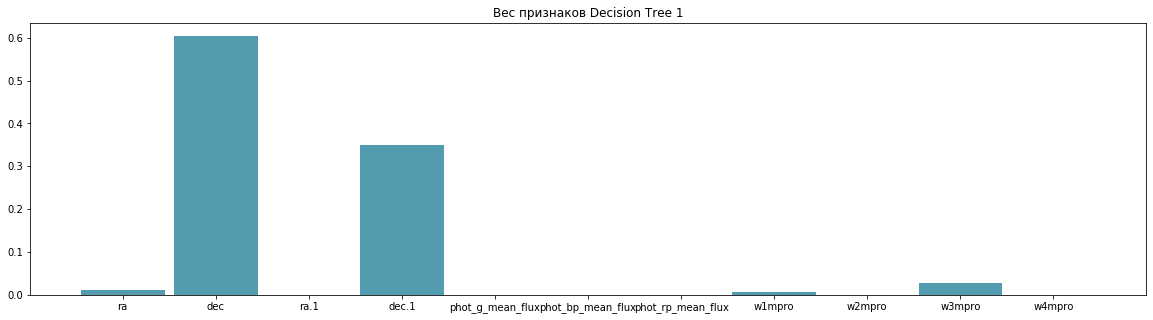

In [31]:
col_lab = []
for i in X_train.columns:
    col_lab.append(i)

barplot(col_lab, weight_f, '', '', '', 'Вес признаков Decision Tree 1', 20, 5)

In [32]:
xpp = x.drop(columns=['dec', 'dec.1'])

dt1 = DecisionTreeClassifier()
dt1 = dt1.fit(xpp, yy)
tr2pp = tr2.drop(columns=['dec', 'dec.1'])
res = dt1.predict(tr2pp)

print('accuracy_score: ', accuracy_score(yx, res))
print('precision_score: ', precision_score(yx, res))
print('recall_score: ', recall_score(yx, res))
print('f1_score: ', f1_score(yx, res))
print()

print(dt1.n_features_)
weight_f = dt1.feature_importances_
print(weight_f)

print('------------------------------------')
tr3pp = tr3.drop(columns=['dec', 'dec.1'])
res = dt1.predict(tr3pp)

print('accuracy_score: ', accuracy_score(yz, res))
print('precision_score: ', precision_score(yz, res))
print('recall_score: ', recall_score(yz, res))
print('f1_score: ', f1_score(yz, res))
print()

print(dt1.n_features_)
weight_f = dt1.feature_importances_
print(weight_f)

print('------------------------------------')



accuracy_score:  0.9295421283713151
precision_score:  0.9145869947275923
recall_score:  0.9651335311572701
f1_score:  0.9391806533116767

9
[0.25069482 0.28479806 0.02231561 0.35361111 0.03167399 0.01980002
 0.         0.01517687 0.02192953]
------------------------------------
accuracy_score:  0.8831666666666667
precision_score:  0.7450796626054358
recall_score:  0.9101316542644533
f1_score:  0.8193764493687195

9
[0.25069482 0.28479806 0.02231561 0.35361111 0.03167399 0.01980002
 0.         0.01517687 0.02192953]
------------------------------------


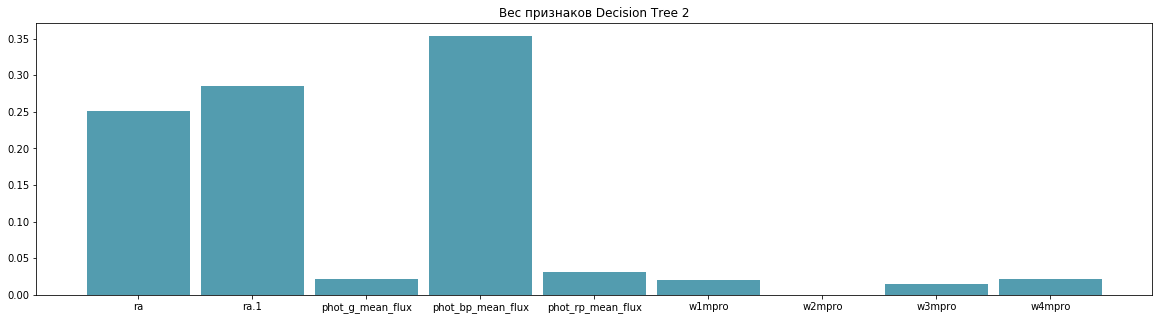

In [33]:
col_lab = []
for i in xpp.columns:
    col_lab.append(i)

barplot(col_lab, weight_f, '', '', '', 'Вес признаков Decision Tree 2', 20, 5)

In [34]:
pp = xpp.drop(columns=['phot_bp_mean_flux'])

dt1 = DecisionTreeClassifier()
dt1 = dt1.fit(pp, yy)
tr2pp = tr2pp.drop(columns=['phot_bp_mean_flux'])
res = dt1.predict(tr2pp)

print('accuracy_score: ', accuracy_score(yx, res))
print('precision_score: ', precision_score(yx, res))
print('recall_score: ', recall_score(yx, res))
print('f1_score: ', f1_score(yx, res))
print()

print(dt1.n_features_)
weight_f = dt1.feature_importances_
print(weight_f)

print('------------------------------------')
tr3pp = tr3pp.drop(columns=['phot_bp_mean_flux'])
res = dt1.predict(tr3pp)

print('accuracy_score: ', accuracy_score(yz, res))
print('precision_score: ', precision_score(yz, res))
print('recall_score: ', recall_score(yz, res))
print('f1_score: ', f1_score(yz, res))
print()

print(dt1.n_features_)
weight_f = dt1.feature_importances_
print(weight_f)

print('------------------------------------')


accuracy_score:  0.8889818105791344
precision_score:  0.8527207559465624
recall_score:  0.9706973293768546
f1_score:  0.9078924544666088

8
[0.25863849 0.35861048 0.23217377 0.09423458 0.00376066 0.01245961
 0.01434305 0.02577935]
------------------------------------
accuracy_score:  0.8261666666666667
precision_score:  0.6518550474547024
recall_score:  0.8649112764739554
f1_score:  0.743419434194342

8
[0.25863849 0.35861048 0.23217377 0.09423458 0.00376066 0.01245961
 0.01434305 0.02577935]
------------------------------------


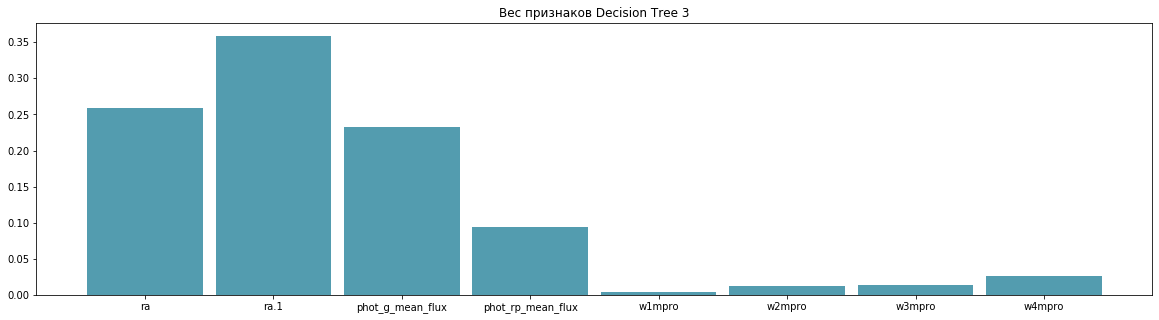

In [35]:
col_lab = []
for i in pp.columns:
    col_lab.append(i)

barplot(col_lab, weight_f, '', '', '', 'Вес признаков Decision Tree 3', 20, 5)

In [36]:
model2 = lgb.LGBMClassifier(n_estimators=100, silent=True,  num_leaves = 25, learning_rate = 0.03, random_state = 27)
model2 = model2.fit(x, yy)
res_lgb = model2.predict(X_val)
res = res_lgb

print('accuracy_score: ', accuracy_score(y_val, res))
print('precision_score: ', precision_score(y_val, res))
print('recall_score: ', recall_score(y_val, res))
print('f1_score: ', f1_score(y_val, res))
print()

weight_f = model2.feature_importances_
print(weight_f)

print('------------------------------------')
res = model2.predict(tr2)

print('accuracy_score: ', accuracy_score(yx, res))
print('precision_score: ', precision_score(yx, res))
print('recall_score: ', recall_score(yx, res))
print('f1_score: ', f1_score(yx, res))
print()

weight_f = model2.feature_importances_
print(weight_f)

print('------------------------------------')
res = model2.predict(tr3)

print('accuracy_score: ', accuracy_score(yz, res))
print('precision_score: ', precision_score(yz, res))
print('recall_score: ', recall_score(yz, res))
print('f1_score: ', f1_score(yz, res))
print()

weight_f = model2.feature_importances_
print(weight_f)

print('------------------------------------')

res = model2.predict(tr4)

print('accuracy_score: ', accuracy_score(yf, res))
print('precision_score: ', precision_score(yf, res))
print('recall_score: ', recall_score(yf, res))
print('f1_score: ', f1_score(yf, res))
print()

accuracy_score:  0.9984532095901005
precision_score:  0.9984984984984985
recall_score:  0.9984984984984985
f1_score:  0.9984984984984985

[380 389  81 363  35  42 136 179 165  30 150]
------------------------------------
accuracy_score:  0.8068158059795107
precision_score:  0.9005424954792043
recall_score:  0.7388724035608308
f1_score:  0.8117359413202933

[380 389  81 363  35  42 136 179 165  30 150]
------------------------------------
accuracy_score:  1.0
precision_score:  1.0
recall_score:  1.0
f1_score:  1.0

[380 389  81 363  35  42 136 179 165  30 150]
------------------------------------
accuracy_score:  0.767587440381558
precision_score:  0.4410112359550562
recall_score:  0.8181344450234497
f1_score:  0.5730972805256435



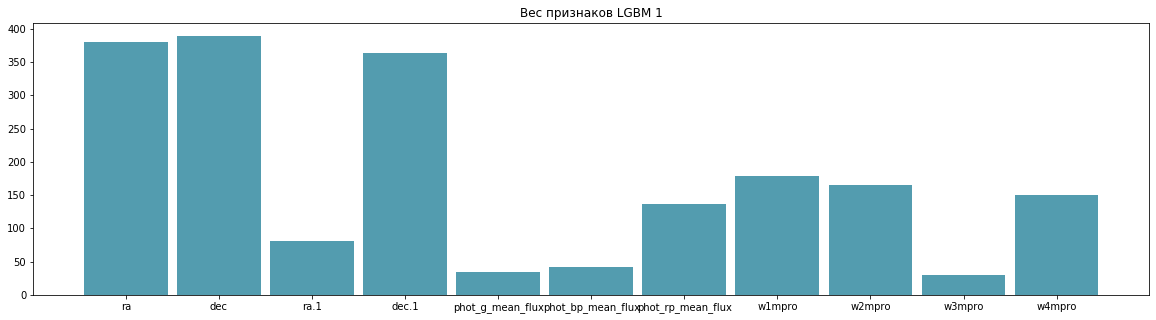

In [37]:
col_lab = []
for i in X_train.columns:
    col_lab.append(i)

barplot(col_lab, weight_f, '', '', '', 'Вес признаков LGBM 1', 20, 5)

In [38]:
model2  = KNeighborsClassifier(n_neighbors=3, algorithm='auto', leaf_size=10)
model2 = model2.fit(x, yy)
res_lgb = model2.predict(X_val)
res = res_lgb

print('accuracy_score: ', accuracy_score(y_val, res))
print('precision_score: ', precision_score(y_val, res))
print('recall_score: ', recall_score(y_val, res))
print('f1_score: ', f1_score(y_val, res))
print()


print('------------------------------------')
res = model2.predict(tr2)

print('accuracy_score: ', accuracy_score(yx, res))
print('precision_score: ', precision_score(yx, res))
print('recall_score: ', recall_score(yx, res))
print('f1_score: ', f1_score(yx, res))
print()


print('------------------------------------')
res = model2.predict(tr3)

print('accuracy_score: ', accuracy_score(yz, res))
print('precision_score: ', precision_score(yz, res))
print('recall_score: ', recall_score(yz, res))
print('f1_score: ', f1_score(yz, res))
print()

print('------------------------------------')

res = model2.predict(tr4)

print('accuracy_score: ', accuracy_score(yf, res))
print('precision_score: ', precision_score(yf, res))
print('recall_score: ', recall_score(yf, res))
print('f1_score: ', f1_score(yf, res))
print()

accuracy_score:  0.9280742459396751
precision_score:  0.920704845814978
recall_score:  0.9414414414414415
f1_score:  0.9309576837416481

------------------------------------
accuracy_score:  0.688689107254861
precision_score:  0.66140679326023
recall_score:  0.9172848664688428
f1_score:  0.7686091686091687

------------------------------------
accuracy_score:  0.4498333333333333
precision_score:  0.3351018675721562
recall_score:  0.9038351459645106
f1_score:  0.48893017494968266

------------------------------------
accuracy_score:  0.32442368839427665
precision_score:  0.2064485081809432
recall_score:  0.89421573736321
f1_score:  0.3354510800508259



In [39]:
model2  = SVC(verbose = True, kernel = 'linear', tol = 0.0001,gamma = 'auto', random_state = 24)
model2 = model2.fit(x, yy)
res_lgb = model2.predict(X_val)
res = res_lgb

print('accuracy_score: ', accuracy_score(y_val, res))
print('precision_score: ', precision_score(y_val, res))
print('recall_score: ', recall_score(y_val, res))
print('f1_score: ', f1_score(y_val, res))
print()


print('------------------------------------')
res = model2.predict(tr2)

print('accuracy_score: ', accuracy_score(yx, res))
print('precision_score: ', precision_score(yx, res))
print('recall_score: ', recall_score(yx, res))
print('f1_score: ', f1_score(yx, res))
print()


print('------------------------------------')
res = model2.predict(tr3)

print('accuracy_score: ', accuracy_score(yz, res))
print('precision_score: ', precision_score(yz, res))
print('recall_score: ', recall_score(yz, res))
print('f1_score: ', f1_score(yz, res))
print()

print('------------------------------------')

res = model2.predict(tr4)

print('accuracy_score: ', accuracy_score(yf, res))
print('precision_score: ', precision_score(yf, res))
print('recall_score: ', recall_score(yf, res))
print('f1_score: ', f1_score(yf, res))
print()

[LibSVM]accuracy_score:  0.9389017788089714
precision_score:  0.9536321483771252
recall_score:  0.9264264264264265
f1_score:  0.9398324447829399

------------------------------------
accuracy_score:  0.6136316119590215
precision_score:  0.650354609929078
recall_score:  0.68026706231454
f1_score:  0.6649746192893401

------------------------------------
accuracy_score:  0.7463333333333333
precision_score:  0.5417130144605117
recall_score:  0.8362907842014883
f1_score:  0.6575157515751575

------------------------------------
accuracy_score:  0.8748012718600954
precision_score:  0.6727844782380703
recall_score:  0.6685773840541949
f1_score:  0.6706743335075798



In [40]:
m = len(x.columns)
p = len(yy.drop_duplicates())
print(m)
print(p)
mlp = MLPClassifier(hidden_layer_sizes=((m+p)*150, ), solver = 'adam', learning_rate_init=0.01, max_iter=200, tol = 0.00001, verbose = False)
mpl = mlp.fit(x, yy)
res_mlp = mpl.predict(X_val)
res = res_mlp

print('accuracy_score: ', accuracy_score(y_val, res))
print('precision_score: ', precision_score(y_val, res))
print('recall_score: ', recall_score(y_val, res))
print('f1_score: ', f1_score(y_val, res))
print()


print('------------------------------------')
res = mpl.predict(tr2)

print('accuracy_score: ', accuracy_score(yx, res))
print('precision_score: ', precision_score(yx, res))
print('recall_score: ', recall_score(yx, res))
print('f1_score: ', f1_score(yx, res))
print()


print('------------------------------------')
res = mpl.predict(tr3)

print('accuracy_score: ', accuracy_score(yz, res))
print('precision_score: ', precision_score(yz, res))
print('recall_score: ', recall_score(yz, res))
print('f1_score: ', f1_score(yz, res))
print()

print('------------------------------------')

res = mpl.predict(tr4)

print('accuracy_score: ', accuracy_score(yf, res))
print('precision_score: ', precision_score(yf, res))
print('recall_score: ', recall_score(yf, res))
print('f1_score: ', f1_score(yf, res))
print()

11
2


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


accuracy_score:  0.9010054137664346
precision_score:  0.8502604166666666
recall_score:  0.9804804804804805
f1_score:  0.9107391910739191

------------------------------------
accuracy_score:  0.7183775872883128
precision_score:  0.6900535362073824
recall_score:  0.9083827893175074
f1_score:  0.7843074459567656

------------------------------------
accuracy_score:  0.5851666666666666
precision_score:  0.40185185185185185
recall_score:  0.86949055523755
f1_score:  0.5496652795368192

------------------------------------
accuracy_score:  0.7131359300476947
precision_score:  0.39780405405405406
recall_score:  0.9817613340281397
f1_score:  0.5661908339594289



In [62]:
modelx = xgb.XGBClassifier()
modelx = modelx.fit(x, yy)
res_xgb = modelx.predict(X_val)
res = res_xgb

print('accuracy_score: ', accuracy_score(y_val, res))
print('precision_score: ', precision_score(y_val, res))
print('recall_score: ', recall_score(y_val, res))
print('f1_score: ', f1_score(y_val, res))
print()

weight_f = modelx.feature_importances_
print(weight_f)

print('------------------------------------')
res = modelx.predict(tr2)

print('accuracy_score: ', accuracy_score(yx, res))
print('precision_score: ', precision_score(yx, res))
print('recall_score: ', recall_score(yx, res))
print('f1_score: ', f1_score(yx, res))
print()

weight_f = modelx.feature_importances_
print(weight_f)

print('------------------------------------')
res = modelx.predict(tr3)

print('accuracy_score: ', accuracy_score(yz, res))
print('precision_score: ', precision_score(yz, res))
print('recall_score: ', recall_score(yz, res))
print('f1_score: ', f1_score(yz, res))
print()

weight_f = modelx.feature_importances_
print(weight_f)

print('------------------------------------')

res = modelx.predict(tr4)

print('accuracy_score: ', accuracy_score(yf, res))
print('precision_score: ', precision_score(yf, res))
print('recall_score: ', recall_score(yf, res))
print('f1_score: ', f1_score(yf, res))
print()


accuracy_score:  0.9984508133230054
precision_score:  0.9970014992503748
recall_score:  1.0
f1_score:  0.9984984984984985

[4.6092954e-02 5.2118909e-01 0.0000000e+00 2.0620330e-01 2.8853072e-04
 9.5590943e-04 1.0736411e-03 2.3366598e-02 1.3451791e-01 4.4980329e-02
 2.1331789e-02]
------------------------------------
accuracy_score:  0.8243525480367586
precision_score:  0.9195561719833565
recall_score:  0.7488704819277109
f1_score:  0.8254824652417515

[4.6092954e-02 5.2118909e-01 0.0000000e+00 2.0620330e-01 2.8853072e-04
 9.5590943e-04 1.0736411e-03 2.3366598e-02 1.3451791e-01 4.4980329e-02
 2.1331789e-02]
------------------------------------
accuracy_score:  0.9995
precision_score:  1.0
recall_score:  0.998282770463652
f1_score:  0.9991406473789745

[4.6092954e-02 5.2118909e-01 0.0000000e+00 2.0620330e-01 2.8853072e-04
 9.5590943e-04 1.0736411e-03 2.3366598e-02 1.3451791e-01 4.4980329e-02
 2.1331789e-02]
------------------------------------
accuracy_score:  0.5758147853736089
precisio

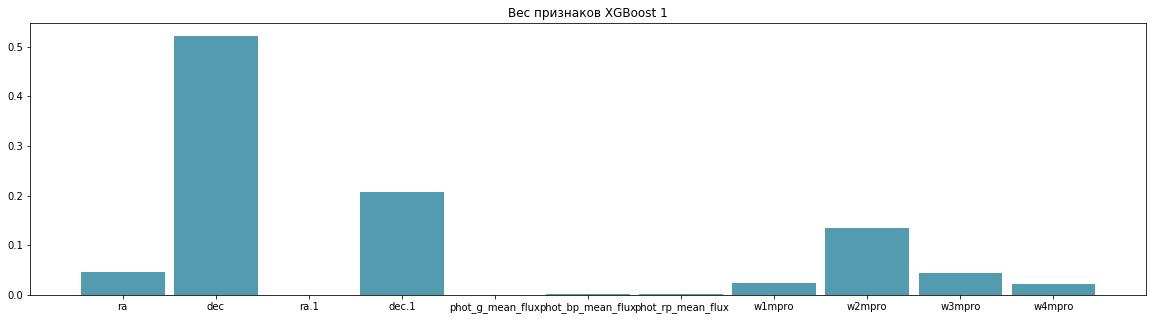

In [63]:
col_lab = []
for i in X_train.columns:
    col_lab.append(i)

barplot(col_lab, weight_f, '', '', '', 'Вес признаков XGBoost 1', 20, 5)

In [67]:
dd = euclid_distance(tr1)


dd['match'] =  [1 if x < 0.1 else 0 for x in dd['eucl']] #0.01-0.001
print('accuracy_score: ', accuracy_score(dd['matched'], dd['match']))
print('precision_score: ', precision_score(dd['matched'], dd['match']))
print('recall_score: ', recall_score(dd['matched'], dd['match']))
print('f1_score: ', f1_score(dd['matched'], dd['match']))
print()

tt2['matched'] = yx
dd = euclid_distance(tt2)


dd['match'] =  [1 if x < 1 else 0 for x in dd['eucl']] #0.01-0.001
print('accuracy_score: ', accuracy_score(dd['matched'], dd['match']))
print('precision_score: ', precision_score(dd['matched'], dd['match']))
print('recall_score: ', recall_score(dd['matched'], dd['match']))
print('f1_score: ', f1_score(dd['matched'], dd['match']))
print()

dd = euclid_distance(tr31)


dd['match'] =  [1 if x < 1 else 0 for x in dd['eucl']] #0.01-0.001
print('accuracy_score: ', accuracy_score(dd['matched'], dd['match']))
print('precision_score: ', precision_score(dd['matched'], dd['match']))
print('recall_score: ', recall_score(dd['matched'], dd['match']))
print('f1_score: ', f1_score(dd['matched'], dd['match']))
print()

dd = euclid_distance(tr1)


dd['match'] =  [1 if x < 1 else 0 for x in dd['eucl']] #0.01-0.001
print('accuracy_score: ', accuracy_score(dd['matched'], dd['match']))
print('precision_score: ', precision_score(dd['matched'], dd['match']))
print('recall_score: ', recall_score(dd['matched'], dd['match']))
print('f1_score: ', f1_score(dd['matched'], dd['match']))
print()


accuracy_score:  0.4452798663324979
precision_score:  0.5
recall_score:  0.00037650602409638556
f1_score:  0.0007524454477050415

accuracy_score:  0.4849624060150376
precision_score:  0.7199074074074074
recall_score:  0.1170933734939759
f1_score:  0.20142487046632127

accuracy_score:  0.8110095389507154
precision_score:  1.0
recall_score:  0.008858780614903595
f1_score:  0.017561983471074377

accuracy_score:  0.4849624060150376
precision_score:  0.7199074074074074
recall_score:  0.1170933734939759
f1_score:  0.20142487046632127



In [68]:
dd = euclid_distance(tt2)


dd['match'] =  [1 if x < 2 else 0 for x in dd['eucl']] #0.01-0.001
print('accuracy_score: ', accuracy_score(dd['matched'], dd['match']))
print('precision_score: ', precision_score(dd['matched'], dd['match']))
print('recall_score: ', recall_score(dd['matched'], dd['match']))
print('f1_score: ', f1_score(dd['matched'], dd['match']))
print()

accuracy_score:  0.6209273182957393
precision_score:  0.7345231455660903
recall_score:  0.49585843373493976
f1_score:  0.5920431557653405



In [69]:
dd = euclid_distance(tt2)


dd['match'] =  [1 if x < 0.1 else 0 for x in dd['eucl']] #0.01-0.001
print('accuracy_score: ', accuracy_score(dd['matched'], dd['match']))
print('precision_score: ', precision_score(dd['matched'], dd['match']))
print('recall_score: ', recall_score(dd['matched'], dd['match']))
print('f1_score: ', f1_score(dd['matched'], dd['match']))
print()

accuracy_score:  0.4452798663324979
precision_score:  0.5
recall_score:  0.00037650602409638556
f1_score:  0.0007524454477050415

